In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import tensorflow as tf
import keras
import keras.models as km
import keras.layers as kl
import keras.utils as ku
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
import skimage.color as skc
from skimage.transform import resize
from skimage.io import imsave, imshow
from keras.applications.vgg19 import VGG19

2023-06-18 22:09:10.635797: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-18 22:09:10.664396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
vgg_model = VGG19()

2023-06-18 22:09:11.860065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-18 22:09:11.863338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-18 22:09:11.863440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

574710816/574710816 [==============================] - 16s 0us/step


In [4]:
encoder_model = km.Sequential(
    vgg_model.layers[:-5]
)

In [5]:
encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [6]:
# freeze VGG16 layers to keep feature extractors the same
for layer in encoder_model.layers:
    layer.trainable = False

In [7]:
TRAIN_PATH = '/app/data/imagenet_data/train/'

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224, 224),
    batch_size=128,
    class_mode=None
)

Found 54963 images belonging to 1 classes.


In [14]:
batches = train.n // train.batch_size
batches

429

In [ ]:
for i in tqdm(range(batches)):
    b = train[i]
    if i == 428:
        print(b)

In [10]:
def create_XY(data):
    X = []
    Y = []
    for img in data:
        try:
            lab = skc.rgb2lab(img)
            X.append(lab[:, :, 0])
            Y.append(lab[:, :, 1:] / 128)
        except:
            print('error')
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(X.shape + (1,))
    return X, Y

In [11]:
def out_vgg(X, vgg_model):
    vgg_features = []
    for i, sample in enumerate(X):
        sample = skc.gray2rgb(sample)
        sample = sample.reshape((1, 224, 224, 3))
        prediction = vgg_model.predict(sample, verbose=0)
        prediction = prediction.reshape((14, 14, 512))
        vgg_features.append(prediction)
    vgg_features = np.array(vgg_features)
    return vgg_features

In [12]:
def run_encoder_vgg(data, vgg_model):
    X, Y = create_XY(data)
    vgg_features = out_vgg(X, vgg_model)
    return vgg_features, Y

In [13]:
tensorboard_callback = TensorBoard(log_dir='/app/vgg19_tensorboard_logs', histogram_freq=0, write_graph=True, write_images=True)

In [18]:
decoder_model = km.Sequential()
decoder_model.add(kl.Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(14, 14, 512)))
decoder_model.add(kl.Conv2D(128, (3, 3), activation='relu', padding='same'))
# decoder_model.add(kl.UpSampling2D((2, 2)))
decoder_model.add(kl.Conv2D(64, (3, 3), activation='relu', padding='same'))
decoder_model.add(kl.UpSampling2D((2, 2)))
decoder_model.add(kl.Conv2D(32, (3, 3), activation='relu', padding='same'))
decoder_model.add(kl.UpSampling2D((2, 2)))
decoder_model.add(kl.Conv2D(16, (3, 3), activation='relu', padding='same'))
decoder_model.add(kl.UpSampling2D((2, 2)))
decoder_model.add(kl.Conv2D(2, (3, 3), activation='tanh', padding='same'))
decoder_model.add(kl.UpSampling2D((2, 2)))

decoder_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [19]:
train.n / train.batch_size

429.3984375

In [20]:
hists = []
start = 0
end = 30
for i in tqdm(range(start, end)):
    vgg_features, Y = run_encoder_vgg(train[i], encoder_model)
    hist = decoder_model.fit(vgg_features, Y, validation_split=0.1, epochs=30, batch_size=32, verbose=0, callbacks=[tensorboard_callback])
    hists.append(hist)

  0%|          | 0/30 [00:00<?, ?it/s]2023-06-18 21:41:43.020078: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2f9e01e8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-18 21:41:43.020102: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-06-18 21:41:43.022870: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-18 21:41:43.101930: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 30/30 [03:26<00:00,  6.89s/it]


In [21]:
concatted_histories = []
for hist in hists:
    concatted_histories.append(pd.DataFrame(hist.history))

df_hist = pd.concat(concatted_histories)
df_hist.to_csv('/app/output/transfer_learning_histories.csv')

In [22]:
TEST_PATH = '/app/data/imagenet_data/test/color/'

In [23]:
files = os.listdir(TEST_PATH)[:100]

In [24]:
def predict_grayscal2rgb(file_paths):
    rgb_images = []
    for file in tqdm(file_paths):
        test = ku.img_to_array(ku.load_img(os.path.join(TEST_PATH, file)))
        test = resize(test, (224, 224), anti_aliasing=True)
        test *= 1.0 / 255
        lab = skc.rgb2lab(test)
        l = lab[:, :, 0]
        L = skc.gray2rgb(l)
        L = L.reshape((1, 224, 224, 3))
        vggpred = encoder_model.predict(L, verbose=0)
        ab = decoder_model.predict(vggpred, verbose=0)
        ab = ab * 128

        cur = np.zeros((224, 224, 3))
        cur[:, :, 0] = l
        cur[:, :, 1:] = ab

        rgb_img = skc.lab2rgb(cur)
        rgb_img = ( rgb_img * 256 ).astype(np.uint8)
        rgb_images.append(rgb_img)

    return rgb_images

In [25]:
rgb_images = predict_grayscal2rgb(files)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1029707/1305768950.py:19: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  rgb_img = skc.lab2rgb(cur)
  1%|          | 1/100 [00:00<00:25,  3.87it/s]/tmp/ipykernel_1029707/1305768950.py:19: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb_img = skc.lab2rgb(cur)
  5%|▌         | 5/100 [00:00<00:09, 10.03it/s]/tmp/ipykernel_1029707/1305768950.py:19: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  rgb_img = skc.lab2rgb(cur)
 25%|██▌       | 25/100 [00:02<00:07, 10.39it/s]/tmp/ipykernel_1029707/1305768950.py:19: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  rgb_img = skc.lab2rgb(cur)
 45%|████▌     | 45/100

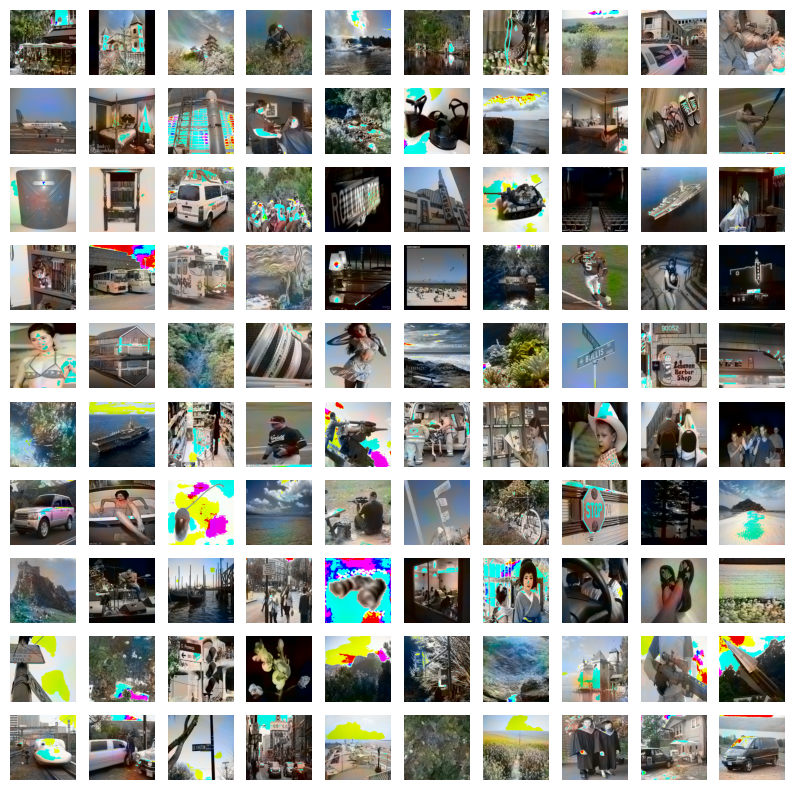

In [26]:
# display images in grid
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i, rgb_img in enumerate(rgb_images):
    ax[i//10, i%10].imshow(rgb_img)
    ax[i//10, i%10].axis('off')